### Load predictions

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os

import numpy as np
import pandas as pd

import misc
import plotting

reload(misc)
reload(plotting)

first_year = 1990

data_dir = '.'
data_file = os.path.join(data_dir, 'immigration_with_metadata_2017_03_13.csv')

data = misc.read_tone_data(data_file, first_year)

last_date = data['date'].max()

print "Loaded data for %d articles" % len(data.index)

Loaded data for 34770 articles


### Group data and plot tone and directness

Grouped data into 92 periods


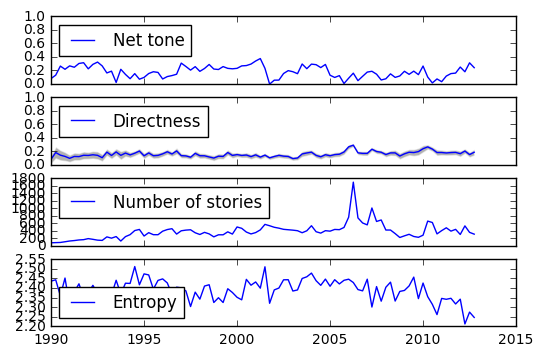

In [3]:
# decide how to group data
#group_by = 'month'
group_by = 'quarter'

reload(misc)
reload(plotting)

grouped = misc.group_tone_data(data, group_by)

print "Grouped data into %d periods" % len(grouped.index)

plotting.plot_variables(grouped)

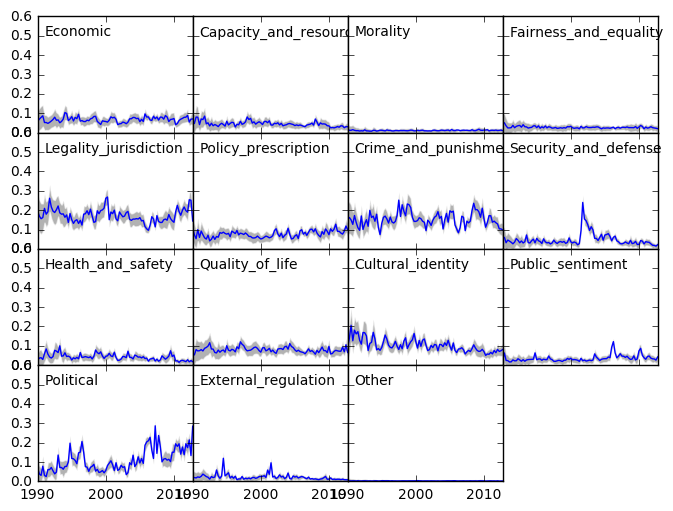

In [4]:
reload(plotting)

plotting.plot_frames(grouped)

### Load polling data

In [63]:
reload(misc)

filename = 'immigration_polls.csv'

polls = misc.load_polls(filename, first_year, last_date)
#polls = polls[polls['Varname'] != 'IMMLEGAL']

print "Loaded %d polls" % len(polls.index)
print polls.shape

Loaded 89 polls
(89, 28)


(0, 1)

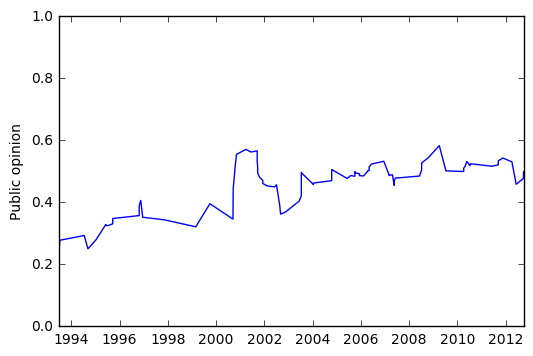

In [64]:
# calculate an exponentially-weighted running average for all polls and plot it

reload(misc)

running_average = misc.calculate_weighted_average(polls)
polls['running_average'] = running_average

plt.plot(polls['date'], polls['running_average']/100.0)
plt.ylabel('Public opinion')
plt.ylim(0, 1)

In [65]:
reload(misc)

combined = misc.combine_polls_with_preceeding_articles(polls, data, n_days=30)
#combined = misc.combine_polls_and_tone(polls, grouped)

print combined.describe()

             Pro    Neutral       Anti  directness     stories    entropy  \
count  89.000000  89.000000  89.000000   89.000000   89.000000  89.000000   
mean    0.502242   0.167679   0.330079    0.178782  179.112360   2.384481   
std     0.052139   0.026098   0.050329    0.060032  133.754731   0.060957   
min     0.393174   0.125105   0.221169    0.093515   56.000000   2.240780   
25%     0.470906   0.149957   0.286846    0.139470  112.000000   2.353280   
50%     0.498950   0.159747   0.336236    0.168514  136.000000   2.394584   
75%     0.538220   0.185903   0.356062    0.193006  191.000000   2.422542   
max     0.631303   0.250843   0.433534    0.375660  763.000000   2.488323   

            tone      Value          N  running_average    IMMRATE     CNNIMM  \
count  89.000000  89.000000  89.000000        88.000000  89.000000  89.000000   
mean    0.172163   0.479022   0.390878         0.458757   0.033708   0.067416   
std     0.099106   0.175517   0.188714         0.080067   0.181

### Plot polling data

Question	Responses
 IMMKEPT	24
IMMLEGAL	20
IMMIGRAT	19
 PSRAIMM	11
  CNNIMM	6
 SPIMMIG	6
 IMMRATE	3



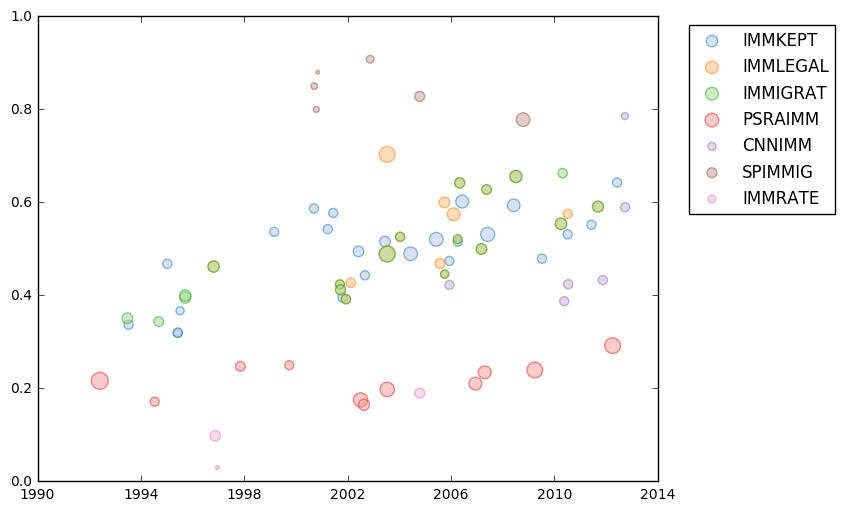

In [66]:
reload(plotting)

plotting.plot_polling_data(combined)
print ""

In [67]:
# create a "salient" variable that is 1 if the number of stories per quarter >= 350, otherwise 0
combined['salient'] = combined.apply(lambda row: int(row['stories'] >= 170), axis=1)


combined['toneXstories'] = combined['tone'] * combined['stories']
combined['directnessXstories'] = combined['directness'] * combined['stories']

combined['proXstories'] = combined['Pro'] * combined['stories']
combined['antiXstories'] = combined['Anti'] * combined['stories']
combined['neutralXstories'] = combined['Neutral'] * combined['stories']

combined['entropyXstories'] = combined['entropy'] * combined['stories']
combined['entropyXtone'] =  combined['entropy'] * combined['tone']
combined['entropyXtoneXstories'] =  combined['entropy'] * combined['tone'] * combined['stories']

combined['toneXdirectness'] = combined['tone'] * combined['directness']
combined['toneXdirectnessXstories'] = combined['tone'] * combined['directness'] * combined['stories']

combined['entropyXtoneXdirectness'] = combined['entropy'] * combined['tone'] * combined['directness']


combined['toneXsalient'] = combined['tone'] * combined['salient']
combined['directnessXsalient'] = combined['directness'] * combined['salient']

combined['logStories'] = np.log(combined['stories'])
combined['toneXlogStories'] = combined['tone'] * combined['logStories']
combined['entropyXtoneXlogStories'] = combined['entropy'] * combined['tone'] * combined['logStories']

#for year in range(1990,2014):
#    combined['post_' + str(year)] = [int(combined.index[i][0] > year) for i in range(len(combined.index))]    
    
#combined['post_event_1990'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1991) for i in range(len(combined.index))]
#combined['post_event_1994'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 1995) for i in range(len(combined.index))]
#combined['post_event_2000'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2000.5) for i in range(len(combined.index))]
#combined['post_event_2001'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2002) for i in range(len(combined.index))]
#combined['post_event_2006'] = [int(combined.index[i][0] + combined.index[i][1]/4.0 > 2006.5) for i in range(len(combined.index))]


In [68]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM>
             + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   8

R-squared:         0.7720
Adj R-squared:     0.7522

Rmse:              0.0525

F-stat (7, 81):    39.1695, p-value:     0.0000

Degrees of Freedom: model 7, resid 81

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2261     0.0582       3.89     0.0002     0.1121     0.3401
       IMMKEPT     0.3669     0.0322      11.40     0.0000     0.3038     0.4300
      IMMLEGAL     0.4052     0.0325      12.46     0.0000     0.3414     0.4690
      IMMIGRAT     0.3535     0.0327      10.82     0.0000     0.2895   

In [69]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT>
             + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   9

R-squared:         0.8017
Adj R-squared:     0.7816

Rmse:              0.0480

F-stat (8, 79):    39.9258, p-value:     0.0000

Degrees of Freedom: model 8, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4632     0.0676       6.85     0.0000     0.3306     0.5958
          tone     0.2408     0.0548       4.39     0.0000     0.1334     0.3483
       IMMKEPT     0.3674     0.0294      12.49     0.0000     0.3097     0.4250
      IMMLEGAL     0.3916     0.0300      13.05    

In [70]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <entropy> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT>
             + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   9

R-squared:         0.7926
Adj R-squared:     0.7718

Rmse:              0.0504

F-stat (8, 80):    38.2131, p-value:     0.0000

Degrees of Freedom: model 8, resid 80

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2912     0.0579       5.03     0.0000     0.1777     0.4048
       entropy    -0.4483     0.0977      -4.59     0.0000    -0.6397    -0.2568
       IMMKEPT     0.3761     0.0309      12.18     0.0000     0.3155     0.4366
      IMMLEGAL     0.4108     0.0312      13.16     0.0000  

In [71]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <entropy> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   10

R-squared:         0.8164
Adj R-squared:     0.7953

Rmse:              0.0465

F-stat (9, 78):    38.5473, p-value:     0.0000

Degrees of Freedom: model 9, resid 78

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4219     0.0664       6.36     0.0000     0.2918     0.5520
          tone     0.2999     0.0553       5.42     0.0000     0.1915     0.4083
       entropy    -0.3707     0.0913      -4.06     0.0001    -0.5497    -0.1916
       IMMKEPT     0.3748     0.0285  

In [72]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <entropy> + <entropyXtone> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   10

R-squared:         0.8228
Adj R-squared:     0.8026

Rmse:              0.0469

F-stat (9, 79):    40.7505, p-value:     0.0000

Degrees of Freedom: model 9, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone    14.3057     2.1346       6.70     0.0000    10.1218    18.4896
       entropy     0.4627     0.1680       2.75     0.0073     0.1335     0.7919
  entropyXtone    -5.9148     0.9032      -6.55     0.0000    -7.6850    -4.1446
       IMMKEPT     0.3215     0.0293      

In [73]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <entropy> + <entropyXtone> + <IMMKEPT>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   11

R-squared:         0.8523
Adj R-squared:     0.8331

Rmse:              0.0420

F-stat (10, 77):    44.4348, p-value:     0.0000

Degrees of Freedom: model 10, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4664     0.0607       7.69     0.0000     0.3475     0.5853
          tone    15.4785     1.9513       7.93     0.0000    11.6539    19.3031
       entropy     0.6307     0.1556       4.05     0.0001     0.3258     0.9357
  entr

In [74]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <toneXstories> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM>
             + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   8

R-squared:         0.7751
Adj R-squared:     0.7556

Rmse:              0.0522

F-stat (7, 81):    39.8716, p-value:     0.0000

Degrees of Freedom: model 7, resid 81

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
  toneXstories     0.0008     0.0002       4.29     0.0000     0.0004     0.0011
       IMMKEPT     0.3614     0.0320      11.30     0.0000     0.2987     0.4241
      IMMLEGAL     0.3975     0.0325      12.22     0.0000     0.3338     0.4613
      IMMIGRAT     0.3461     0.0327      10.58     0.0000     0

In [75]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <toneXstories> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   9

R-squared:         0.7975
Adj R-squared:     0.7770

Rmse:              0.0485

F-stat (8, 79):    38.8959, p-value:     0.0000

Degrees of Freedom: model 8, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4452     0.0691       6.45     0.0000     0.3098     0.5806
  toneXstories     0.0006     0.0002       3.57     0.0006     0.0003     0.0009
       IMMKEPT     0.3639     0.0297      12.23     0.0000     0.3056     0.4222
      IMMLEGAL     0.3878     0.0305      1

In [76]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT>
             + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   9

R-squared:         0.7809
Adj R-squared:     0.7590

Rmse:              0.0518

F-stat (8, 80):    35.6479, p-value:     0.0000

Degrees of Freedom: model 8, resid 80

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2386     0.0575       4.15     0.0001     0.1259     0.3512
       stories     0.0001     0.0000       2.96     0.0041     0.0000     0.0002
       IMMKEPT     0.3551     0.0319      11.12     0.0000     0.2925     0.4177
      IMMLEGAL     0.3942     0.0325      12.14     0.0000  

In [77]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'stories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   10

R-squared:         0.8042
Adj R-squared:     0.7816

Rmse:              0.0480

F-stat (9, 78):    35.5963, p-value:     0.0000

Degrees of Freedom: model 9, resid 78

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4375     0.0695       6.30     0.0000     0.3013     0.5737
          tone     0.2463     0.0550       4.48     0.0000     0.1385     0.3540
       stories     0.0001     0.0000       1.63     0.1080    -0.0000     0.0001
       IMMKEPT     0.3612     0.0296  

In [78]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   10

R-squared:         0.7810
Adj R-squared:     0.7561

Rmse:              0.0521

F-stat (9, 79):    31.3071, p-value:     0.0000

Degrees of Freedom: model 9, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.2163     0.1029       2.10     0.0387     0.0147     0.4179
       stories     0.0001     0.0001       1.04     0.3025    -0.0001     0.0003
  toneXstories     0.0001     0.0005       0.28     0.7836    -0.0008     0.0011
       IMMKEPT     0.3562     0.0323      

In [79]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'stories', 'toneXstories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <toneXstories> + <IMMKEPT>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   11

R-squared:         0.8045
Adj R-squared:     0.7791

Rmse:              0.0483

F-stat (10, 77):    31.6828, p-value:     0.0000

Degrees of Freedom: model 10, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4430     0.0706       6.27     0.0000     0.3046     0.5814
          tone     0.1998     0.1021       1.96     0.0540    -0.0003     0.4000
       stories     0.0000     0.0001       0.22     0.8296    -0.0002     0.0002
  tone

In [80]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <entropy> + <IMMKEPT> + <IMMLEGAL>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   10

R-squared:         0.8005
Adj R-squared:     0.7777

Rmse:              0.0498

F-stat (9, 79):    35.2139, p-value:     0.0000

Degrees of Freedom: model 9, resid 79

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone     0.3012     0.0572       5.26     0.0000     0.1890     0.4134
       stories     0.0001     0.0000       2.88     0.0051     0.0000     0.0002
       entropy    -0.4365     0.0965      -4.52     0.0000    -0.6257    -0.2474
       IMMKEPT     0.3648     0.0307      11.89

In [81]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'entropy'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <entropy> + <IMMKEPT>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   11

R-squared:         0.8188
Adj R-squared:     0.7952

Rmse:              0.0465

F-stat (10, 77):    34.7906, p-value:     0.0000

Degrees of Freedom: model 10, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.3972     0.0681       5.83     0.0000     0.2637     0.5308
          tone     0.3049     0.0554       5.50     0.0000     0.1963     0.4135
       stories     0.0001     0.0000       1.63     0.1073    -0.0000     0.0001
       entr

In [82]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <toneXstories> + <entropy> + <entropyXtone>
             + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM>
             + <SPIMMIG> + <intercept>

Number of Observations:         89
Number of Degrees of Freedom:   12

R-squared:         0.8296
Adj R-squared:     0.8052

Rmse:              0.0466

F-stat (11, 77):    34.0688, p-value:     0.0000

Degrees of Freedom: model 11, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone    14.1346     2.1246       6.65     0.0000     9.9703    18.2988
       stories     0.0001     0.0001       1.57     0.1202    -0.0000     0.0003
  toneXstories    -0.0002     0.0004      -0.37     0.7147    -0.0010     0.000

In [83]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'toneXstories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <toneXstories> + <entropy>
             + <entropyXtone> + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM>
             + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   13

R-squared:         0.8539
Adj R-squared:     0.8305

Rmse:              0.0423

F-stat (12, 75):    36.5297, p-value:     0.0000

Degrees of Freedom: model 12, resid 75

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4492     0.0636       7.06     0.0000     0.3246     0.5739
          tone    15.3129     1.9691       7.78     0.0000    11.4535    19.1724
       stories     0.0000     0.0001       0.33     0.7397

In [27]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['tone', 'stories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <tone> + <stories> + <entropy> + <entropyXtone> + <IMMKEPT>
             + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG> + <intercept>

Number of Observations:         69
Number of Degrees of Freedom:   10

R-squared:         0.8684
Adj R-squared:     0.8483

Rmse:              0.0433

F-stat (9, 59):    43.2430, p-value:     0.0000

Degrees of Freedom: model 9, resid 59

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
          tone    12.1884     2.1230       5.74     0.0000     8.0272    16.3496
       stories     0.0002     0.0000       3.49     0.0009     0.0001     0.0002
       entropy     0.3293     0.1714       1.92     0.0596    -0.0067     0.6652
  entropyXtone    -5.0178     0.8990      -

In [84]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'stories', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <stories> + <entropy> + <entropyXtone>
             + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM>
             + <SPIMMIG> + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   12

R-squared:         0.8538
Adj R-squared:     0.8327

Rmse:              0.0420

F-stat (11, 76):    40.3571, p-value:     0.0000

Degrees of Freedom: model 11, resid 76

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4460     0.0624       7.14     0.0000     0.3237     0.5684
          tone    15.3258     1.9566       7.83     0.0000    11.4908    19.1607
       stories     0.0001     0.0000       1.45     0.1509    -0.0000     0

In [85]:
poll_names = misc.get_top_poll_questions(polls, n=25)[:-1]
columns = ['running_average', 'tone', 'entropy', 'entropyXtone'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <entropy> + <entropyXtone> + <IMMKEPT>
             + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   11

R-squared:         0.8523
Adj R-squared:     0.8331

Rmse:              0.0420

F-stat (10, 77):    44.4348, p-value:     0.0000

Degrees of Freedom: model 10, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4664     0.0607       7.69     0.0000     0.3475     0.5853
          tone    15.4785     1.9513       7.93     0.0000    11.6539    19.3031
       entropy     0.6307     0.1556       4.05     0.0001     0.3258     0.9357
  entr

In [86]:
poll_names = misc.get_top_poll_questions(polls)[:-1]
columns = ['running_average', 'tone', 'logStories', 'toneXlogStories'] + poll_names
fit = pd.ols(y=combined['Value'], x=combined[columns], weights=combined['N'].values)
print fit


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <running_average> + <tone> + <logStories> + <toneXlogStories>
             + <IMMKEPT> + <IMMLEGAL> + <IMMIGRAT> + <PSRAIMM> + <CNNIMM> + <SPIMMIG>
             + <intercept>

Number of Observations:         88
Number of Degrees of Freedom:   11

R-squared:         0.8027
Adj R-squared:     0.7771

Rmse:              0.0485

F-stat (10, 77):    31.3341, p-value:     0.0000

Degrees of Freedom: model 10, resid 77

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
running_average     0.4640     0.0717       6.47     0.0000     0.3235     0.6045
          tone    -0.3194     0.6506      -0.49     0.6249    -1.5946     0.9558
    logStories    -0.0134     0.0251      -0.53     0.5960    -0.0626     0.0358
